Обучите простую модель предсказания цены акций. Используйте рассмотренные на лекции алгоритмы предсказания рядов (не менее двух,например, модель Хольта-Уинтерса и SARIMA). Можно использовать и более сложные алгоритмы предсказания рядов


1. Найдите данные о цене любого биржевого актива

    Данные должны содержать значение цены актива как минимум за каждый день и длительностю как минимум за год.

    Найти данные можно на kaggle или использовать FAANG датасет из 1-й лабораторной


1. Предобработайте данные

    Временной ряд сложно предсказывать по дням. Сделайте ряд по неделям или месяцам

    Удалите из ряда тренд, если он есть. Используйте другие рассмотренные на лекции приёмы


1. Обучите модель

    Обучите модели на 80% временного ряда

    Предскажите оставшиеся 20% (как минимум 3 точки) ряда с помощью моделей

    Отобразите на графике предсказание моделей и истинные данные


1. Посчитайте метрику

    Метрика должна отражать разницу между предсказанными и истинными данными. Можно выбрать меру MAPE, можно предложить свою

# Обучите простую модель предсказания цены акций
- Найдите данные о цене любого биржевого актива - выбраны акции сбебранка с 2008 года по 2022 год.

<AxesSubplot:xlabel='DATE'>

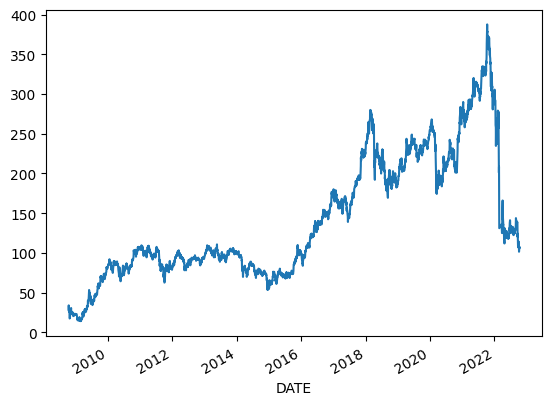

In [57]:
import pandas as pd

df = pd.read_csv('../data/SBER_2.csv', sep=',', index_col='DATE', parse_dates=['DATE'])
df.CLOSE.plot()

# Предобработайте данные
- Временной ряд сложно предсказывать по дням. Сделайте ряд по неделям или месяцам
- Удалите из ряда тренд, если он есть. Используйте другие рассмотренные на лекции приёмы

In [58]:
df = df.resample('M').first()
df.head()

,TIME,OPEN,HIGH,LOW,CLOSE,VOL
DATE,,,,,,
2008-10-31,00:00:00,33.54,34.47,28.30,28.60,131970576
2008-11-30,00:00:00,28.60,30.18,27.10,28.39,112305748
2008-12-31,00:00:00,23.19,23.68,21.95,22.00,133906234
2009-01-31,00:00:00,23.30,23.45,22.90,22.98,29329215
2009-02-28,00:00:00,16.26,16.37,15.35,15.88,206716593


- Воспользуемся логарифмировнанием

<AxesSubplot:xlabel='DATE'>

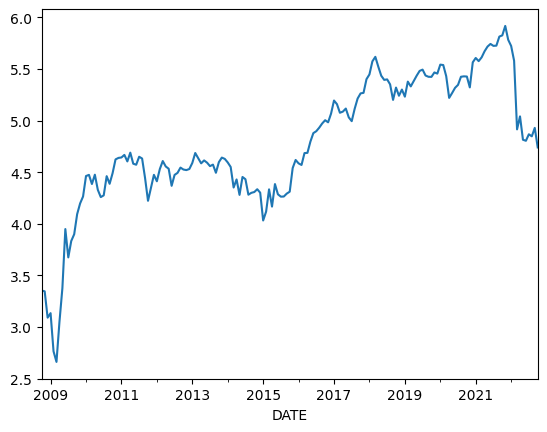

In [59]:
import numpy as np

df['CLOSE_LOG'] = np.log(df['CLOSE'])
df.fillna(method='ffill', inplace=True)
df.CLOSE_LOG.plot()

- Воспользуемся методом seasonal_decompose и разобьем график цены акций на сезоны

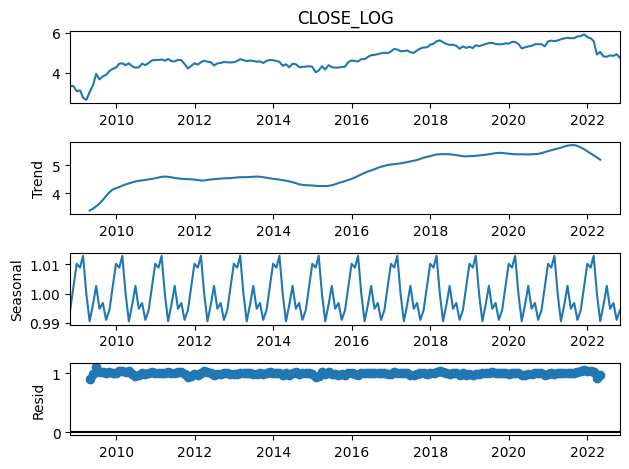

In [60]:
def seasonal_decomposition(data_column):
    from statsmodels.tsa.seasonal import seasonal_decompose
    decomposition = seasonal_decompose(data_column, model='multiplicative')
    decomposition.plot()

seasonal_decomposition(df['CLOSE_LOG'])

- Продифференцируем временной ряд, чтобы избавиться от тренда

<AxesSubplot:xlabel='DATE'>

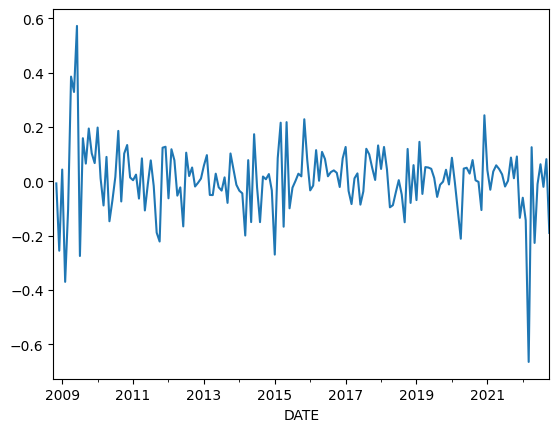

In [61]:
df['CLOSE_LOG_SHIFT1'] = df['CLOSE_LOG'].diff()
df.CLOSE_LOG_SHIFT1.plot()

- Определим обратную к дифференцированию операцию

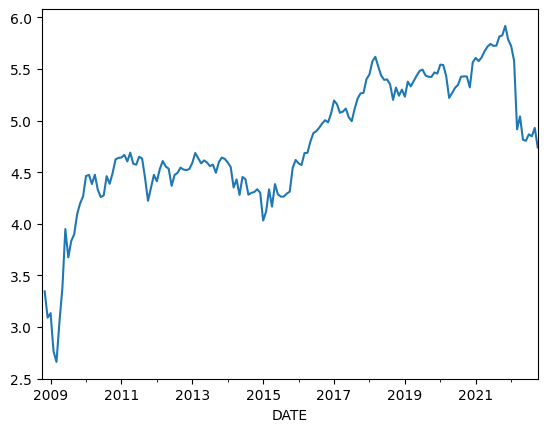

In [62]:
df['CLOSE_LOG_SHIFT1_INVERSE'] = df['CLOSE_LOG_SHIFT1'].cumsum() + df['CLOSE_LOG'][0]
df.CLOSE_LOG_SHIFT1_INVERSE.plot()

df.fillna(method='ffill', inplace=True)

- Dickey–Fuller test

In [63]:
def adf(data_column):
    from statsmodels.tsa.stattools import adfuller
    result = adfuller(data_column)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1] < 0.05:
        print("The time series is stationary")
    else:
        print("The time series is not stationary")

In [64]:
adf(df['CLOSE_LOG_SHIFT1'][1:])

ADF Statistic: -12.764197
p-value: 0.000000
Critical Values:
	1%: -3.470
	5%: -2.879
	10%: -2.576
The time series is stationary


- Изобразим автокорреляцию полученного временного ряда

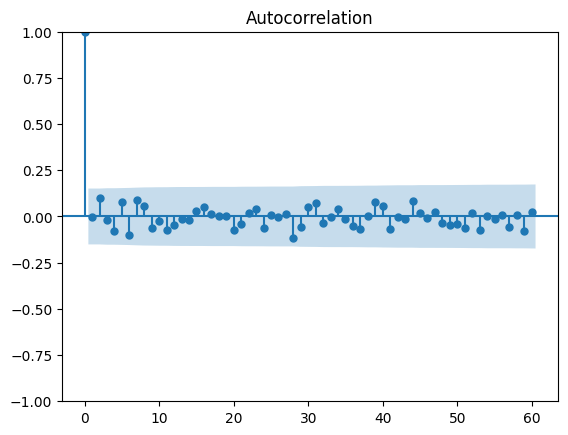

In [65]:
from statsmodels.graphics.tsaplots import plot_acf

def autocorrelation(data_column):
    plot_acf(data_column, lags=60)

autocorrelation(df['CLOSE_LOG_SHIFT1'][1:])

# Обучите модель
- Обучите модели на 80% временного ряда
- Предскажите оставшиеся 20% (как минимум 3 точки) ряда с помощью моделей
- Отобразите на графике предсказание моделей и истинные данные

In [66]:
# ARIMA model
def predict_arima(train, test):
    from pmdarima.arima import auto_arima
    model = auto_arima(train, start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=1, D=1,
                       trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
    model.fit(train)
    return model.predict(n_periods=len(test))

# Holt-Winters method
def predict_holt_winters(train, test):
    from statsmodels.tsa.holtwinters import ExponentialSmoothing
    model = ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='add').fit()
    return model.predict(start=test.index[0], end=test.index[-1])

# SARIMAX method
def predict_sarimax(train, test):
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    model_fit = model.fit(disp=False)
    return model_fit.predict(start=test.index[0], end=test.index[-1])

In [67]:
# Data dividing
def train_test_split(data_column, train_size=0.8):
    train_size = int(len(data_column) * train_size)
    return data_column[0:train_size], data_column[train_size:len(data_column)]

def predict(data_column, data_before_diff):
    train, test = train_test_split(data_column)
    train1, test1 = train_test_split(data_before_diff)

    predictions = \
        [(predict_arima(train, test), 'ARIMA'),
         (predict_holt_winters(train, test), 'Holt-Winters'),
         (predict_sarimax(train, test), 'SARIMAX')]

    plot(train, test, predictions, train1[0], test1[0])

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-114.983, Time=1.66 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-20.239, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-62.438, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.73 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.34 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=0.87 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=inf, Time=1.90 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=inf, Time=0.49 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=inf, Time=2.10 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-80.341, Time=0.36 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=inf, Time=0.73 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=inf, Time=1.41 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-45.392, Time=0.29 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=inf, Time=0.89 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=-87.121, Time=0.63 sec
 A

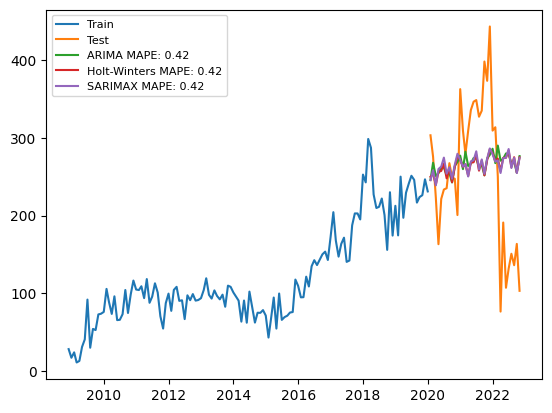

In [68]:
import matplotlib.pyplot as plt

# Reverse after trend removing
def reverse(data_column, diff_value):
    return np.exp(data_column + (data_column.cumsum() + diff_value))

# MAPE metric definition
def get_mape(prediction, test):
    return np.mean(np.abs(prediction - test) / np.abs(test))

def plot(train, test, predictions, train_diff, test_diff):
    train = reverse(train, train_diff)
    test = reverse(test, test_diff)

    # plot the data and test data
    plt.plot(figsize=(20, 18))
    plt.plot(train, label='Train')
    plt.plot(test, label='Test')
    for (prediction, name) in predictions:
        prediction = reverse(prediction, test_diff)
        plt.plot(prediction, label=name + ' MAPE: {:.2f}'.format(get_mape(prediction, test)))
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

predict(df['CLOSE_LOG_SHIFT1'][1:], data_before_diff=df['CLOSE_LOG'])